### Import packages

In [41]:
import sys
sys.path
sys.path.append("/anaconda3/envs/metis/lib/python3.6/site-packages")

In [42]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from mlxtend.plotting import plot_decision_regions #plotting regions

Populating the interactive namespace from numpy and matplotlib


### Read and clean data

In [43]:
df_2017 = pd.read_csv('usa_00004.csv')

In [44]:
mask = df_2017['CISMRTPHN'] == 0
print(df_2017[mask].shape[0] / df_2017.shape[0] * 100, '%', sep = '')

4.719658687665358%


In [45]:
# Filter for California adults only:
df_CA = df_2017.loc[(df_2017.STATEFIP == 2) & (df_2017.AGE >= 18),:].copy()

# Generate unique identifier for each person
df_CA['UNIQUE_ID'] = df_CA['YEAR'].map(str) + df_CA['DATANUM'].map(str) + \
                     df_CA['SERIAL'].map(str) + df_CA['PERNUM'].map(str)

# Set poverty binary (less than 100% of poverty level is 1)
df_CA['POVERTY_BIN'] = np.where(df_CA['POVERTY'] <= 100, 1,0)

# Keep only relevant columns
model_cols = ['UNIQUE_ID', 'PERWT', 'POVERTY_BIN', 'AGE', 'MIGRATE1', 'NCHILD', 'BPL', \
              'CINETHH', 'CISMRTPHN', 'MARST', 'MOMLOC']

df_CA_M = df_CA[model_cols].copy()

# Set 0's to nulls
null_cols = ['MIGRATE1']

# Items not included due to removing too many columns: SPEAKENG, LINGUISOL, OWNERSHP, CITIZEN
# Items excluded due to being highly uncorrelated and removing cols: CINETHH, CISMRTPHN
# NB: OWNERSHP results in a good number of null values

df_CA_M.loc[:, null_cols] = df_CA_M.loc[:, null_cols].replace({0:np.nan})

# Drop nulls
df_CA_M = df_CA_M.dropna()

In [46]:
print('Original shape:', df_CA.shape)
print('Post clean shape:', df_CA_M.shape)

Original shape: (4881, 45)
Post clean shape: (4881, 11)


In [47]:
df_CA.columns

Index(['YEAR', 'DATANUM', 'SERIAL', 'CBSERIAL', 'HHWT', 'STATEFIP', 'METRO',
       'CITY', 'GQ', 'OWNERSHP', 'OWNERSHPD', 'MORTGAGE', 'RENTGRS',
       'HHINCOME', 'VALUEH', 'CINETHH', 'CISMRTPHN', 'SSMC', 'PERNUM', 'PERWT',
       'MOMLOC', 'POPLOC', 'NCHILD', 'SEX', 'AGE', 'MARST', 'BPL', 'BPLD',
       'CITIZEN', 'SPEAKENG', 'HCOVANY', 'HIUFPGBASE', 'HIUFPGINC', 'HIUNPERS',
       'OCC', 'IND', 'POVERTY', 'MIGRATE1', 'MIGRATE1D', 'POVERTY_MOM',
       'POVERTY_POP', 'POVERTY_MOM2', 'POVERTY_POP2', 'UNIQUE_ID',
       'POVERTY_BIN'],
      dtype='object')

In [48]:
# Generate international migration binary
df_CA_M['MIGRATE_BIN'] = np.where(df_CA_M['MIGRATE1'] == 4, 1,0)

# Generate born within the US binary
df_CA_M['BPL_BIN'] = np.where(df_CA_M['BPL'] <= 120, 1,0)

# Generate marriage binary (currently married = 1, not ever married or divorced = 0)
df_CA_M['MARST_BIN'] = np.where(df_CA_M['MARST'] <= 2, 1,0)

# Generate mother in household binary
df_CA_M['MOMLOC_BIN'] = np.where(df_CA_M['MOMLOC'] > 0, 1,0)

0    0.814587
1    0.185413
Name: POVERTY_BIN, dtype: float64


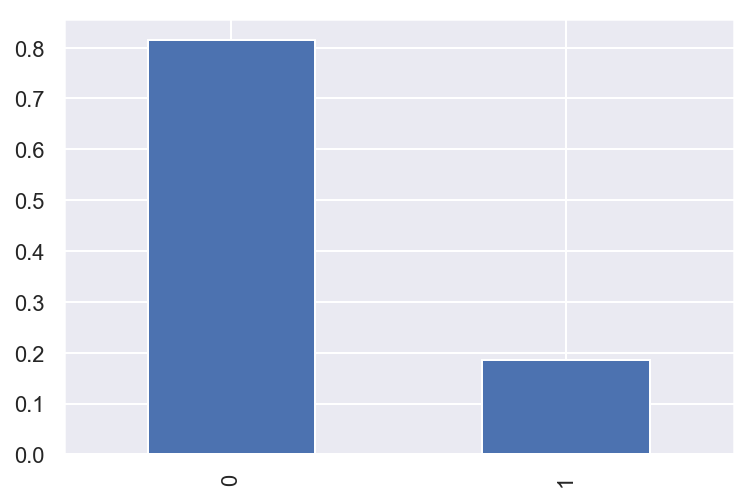

In [49]:
# Visualize % in poverty for overall data
target_pcts = df_CA_M['POVERTY_BIN'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

0    0.814587
1    0.185413
Name: POVERTY_BIN, dtype: float64


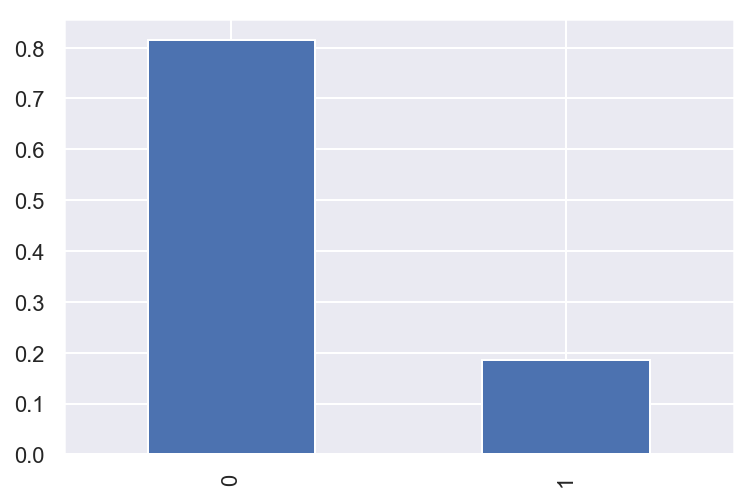

In [50]:
# Visualize % in poverty for overall data
target_pcts = df_CA['POVERTY_BIN'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


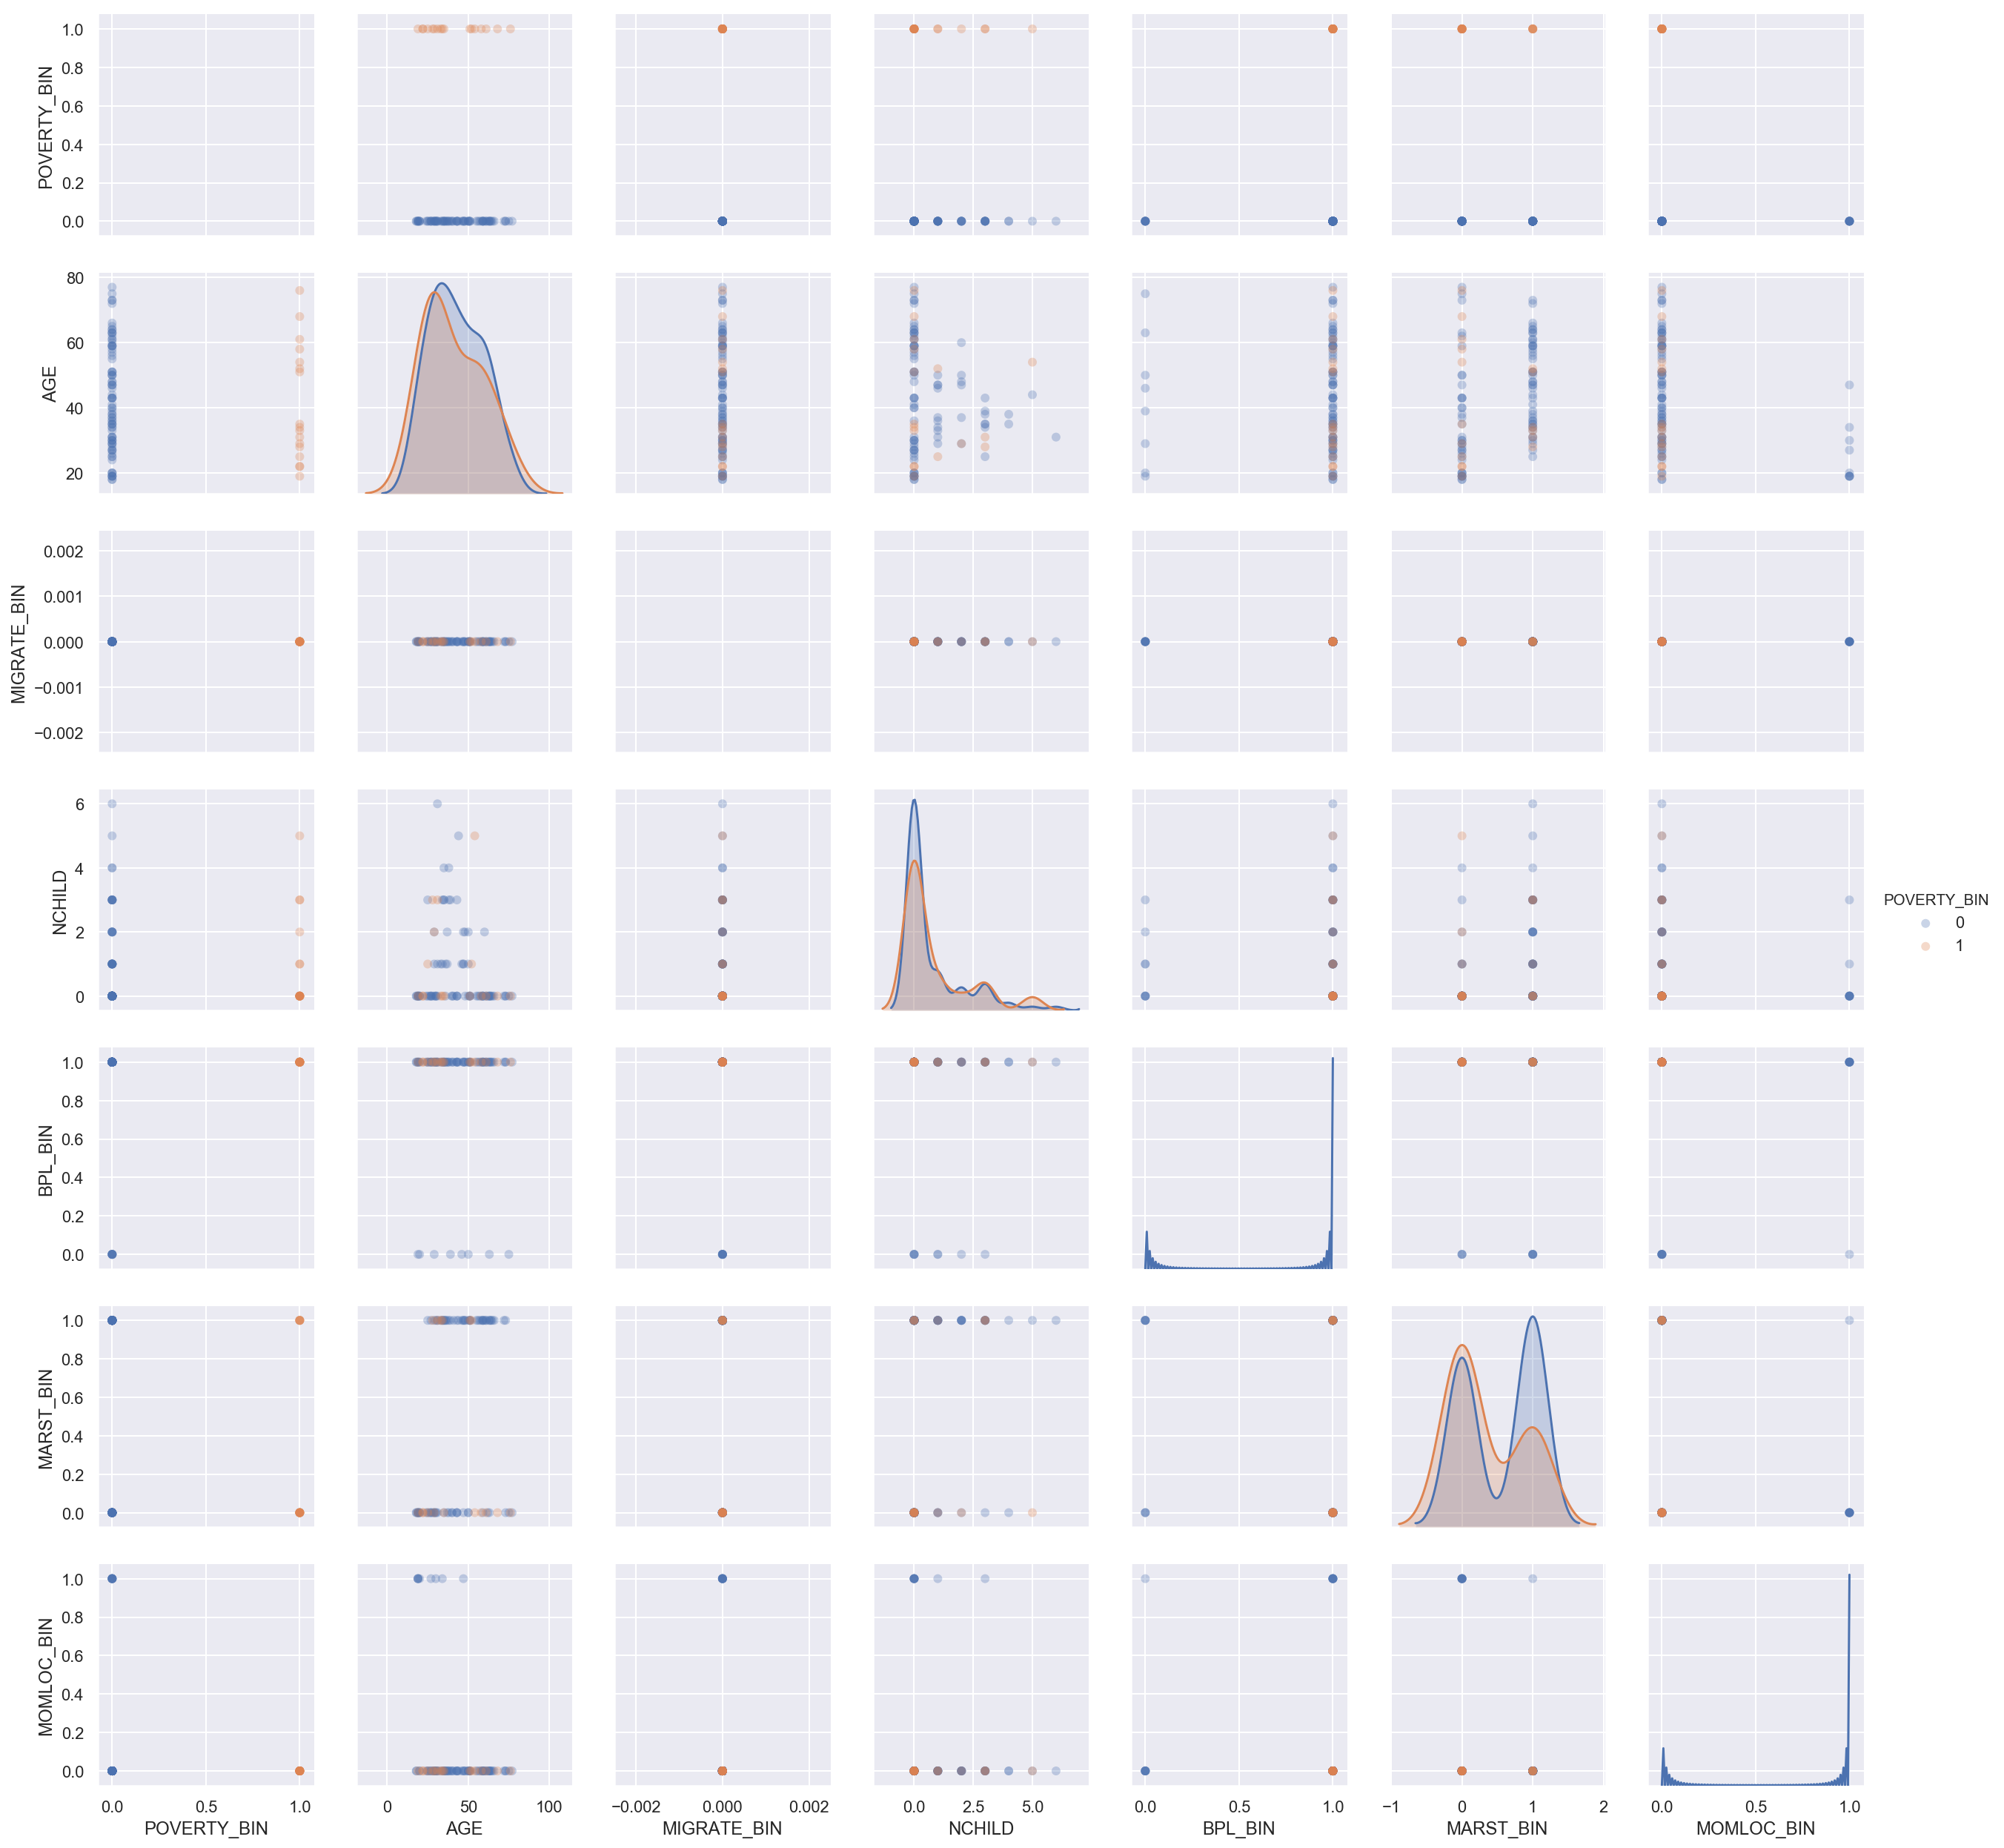

In [51]:
plot_cols = ['POVERTY_BIN', 'AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', \
             'MARST_BIN', 'MOMLOC_BIN']

def plot_features(df, sample_size=500):
    
    sample = (df[plot_cols]
                .sample(100, random_state=20)) 
    
    sns.pairplot(sample,hue='POVERTY_BIN', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_CA_M)

In [52]:
# As the data duplicates the same person based on weights, splits should be done on the unique ID level rather
# than a true train_test_split in sklearn

def get_person_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_people = df['UNIQUE_ID'].unique() 
    test_people = rs.choice(total_people, 
                           size=int(total_people.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['UNIQUE_ID'].isin(test_people)]
    df_te = df[df['UNIQUE_ID'].isin(test_people)] 

    y_tr, y_te = df_tr['POVERTY_BIN'], df_te['POVERTY_BIN']
    
    X_cols = ['AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', 'MARST_BIN']

    X_tr = df_tr[X_cols]
    X_te = df_te[X_cols]
    
    return X_tr, X_te, y_tr, y_te

### Testing Helper Functions

In [53]:
def scores(model, thres, X_tr, y_tr, X_te, y_te):
    
    y_pred = (model.predict_proba(X_te)[:,1]) > thres
    
    print('Accuracy (train):', model.score(X_tr, y_tr))
    print('Accuracy (test):', accuracy_score(y_te, y_pred))
    print('F1_Score (test):', f1_score(y_te, y_pred))
    print('Precision Score (test):', precision_score(y_te, y_pred))
    print('Recall (test):', recall_score(y_te, y_pred))

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = get_person_split_data(df_CA_M_WT)
    model.fit(xtrain, ytrain)
    return f1_score(y_te, model.predict(X_te))
    
def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [54]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,5), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Balancing - SMOTE

In [55]:
# Check the logistic regression
# X_tr, X_te, y_tr, y_te = get_person_split_data(df_CA_M)

X = df_CA_M[['AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', 'MARST_BIN', 'PERWT']]
y = df_CA_M[['POVERTY_BIN']]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

WT_tr = X_tr[['PERWT']].copy()
WT_te = X_te[['PERWT']].copy()

X_tr = X_tr.drop(columns = ['PERWT'])
X_te = X_te.drop(columns = ['PERWT'])

## SMOTE used to generate a close data point
# X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_tr, y_tr)

# Counter(y_smoted)

### Logistic Regression

In [73]:
lr = LogisticRegression(solver='lbfgs', max_iter = 500, n_jobs = -1, class_weight = 'balanced')
lr_fit = lr.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())
scores(lr, 0.5, X_tr, y_tr, X_te, y_te)

Accuracy (train): 0.6618852459016393
Accuracy (test): 0.6683725690890481
F1_Score (test): 0.42348754448398573
Precision Score (test): 0.3123359580052493
Recall (test): 0.6574585635359116


In [74]:
lr.coef_

array([[-0.00862727,  0.59834652,  0.07466964, -0.16699103, -1.67529939]])

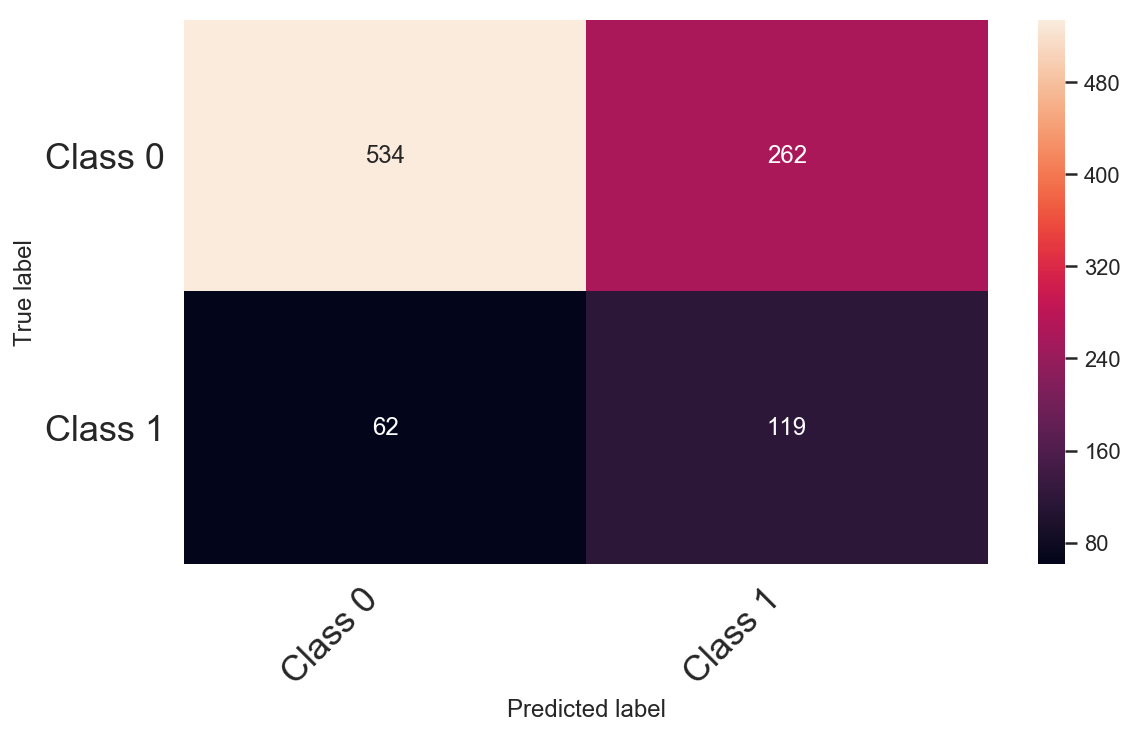

In [75]:
y_pred=lr.predict(X_te)
conf_mat = confusion_matrix(y_true=y_te, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

### Random Forest

In [701]:
randomforest = RandomForestClassifier(n_estimators=100, n_jobs = -1)
randomforest.fit(X_smoted, y_smoted)

scores(randomforest, 0.5, X_smoted, y_smoted, X_te, y_te)

# n_jobs paramter will multi-thred the forest. Set to -1 for multi_thread to speed up processing.

Accuracy (train): 0.7926494615621407
Accuracy (test): 0.6453052945459589
F1_Score (test): 0.2656185502252374
Precision Score (test): 0.1806728844181845
Recall (test): 0.5013210487094371


In [702]:
scores(randomforest, 0.75, X_smoted, y_smoted, X_te, y_te)

Accuracy (train): 0.7926494615621407
Accuracy (test): 0.779203217641552
F1_Score (test): 0.19172431300374437
Precision Score (test): 0.18032591177699517
Recall (test): 0.2046609308312445


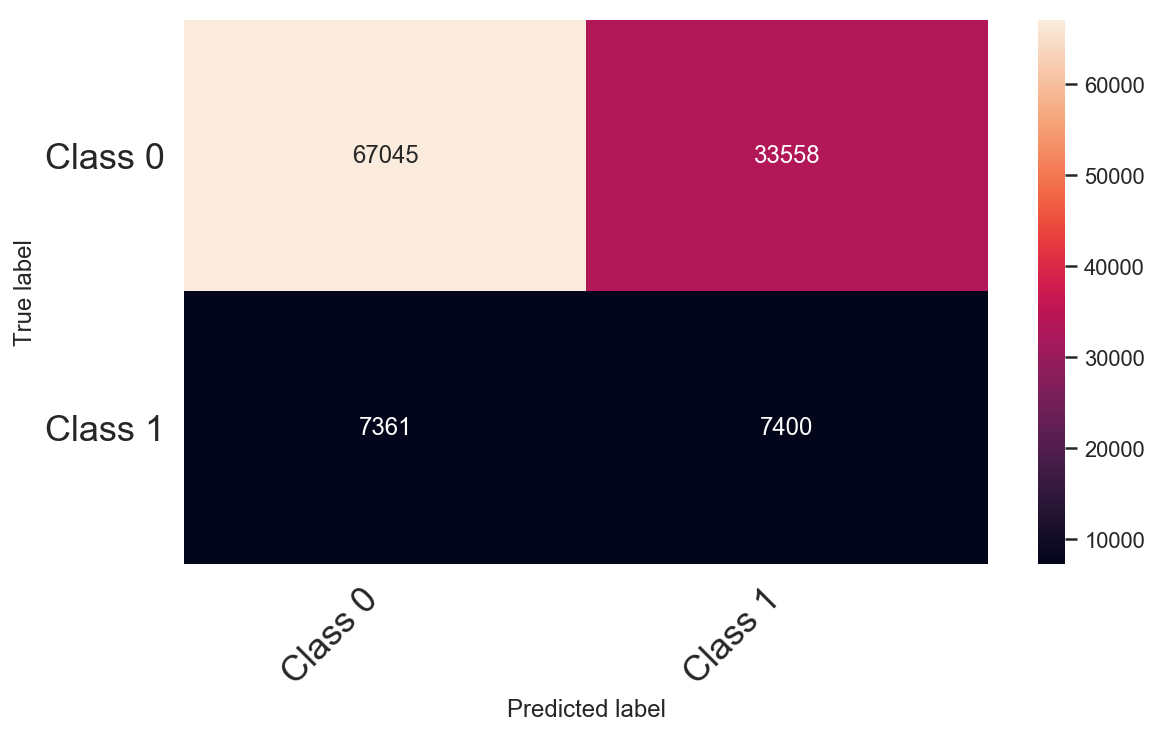

In [703]:
y_pred = randomforest.predict(X_te)
conf_mat = confusion_matrix(y_true=y_te, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

### KNN Model

In [705]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_tr)
scores(knn, 0.5, X_tr, y_tr, X_te, y_te)

Accuracy (train): 0.8545527083713296
Accuracy (test): 0.7772962102562324
F1_Score (test): 0.15028442915729595
Precision Score (test): 0.14681744749596123
Recall (test): 0.15391911117132986


In [ ]:
y_pred = knn.predict(X_te)
conf_mat = confusion_matrix(y_true=y_te, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

### BALANCING - ADASYN

In [561]:
## ADASYN used to generate a close data point
X_adasyn, y_adasyn = ADASYN().fit_sample(X_tr,y_tr)

Counter(y_adasyn)

Counter({0: 376824, 1: 375982})

In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter = 500)
lr_fit = lr.fit(X_smoted, y_smoted)
scores(lr, X_smoted, y_smoted, X_te, y_te)